### Librerias

In [1]:
library(tidyverse) # general

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(ggplot2) # visualización

In [3]:
library(countrycode) # continentes

In [4]:
library(rworldmap) # mapas de calor

Loading required package: sp
### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')


In [5]:
library(gridExtra) # plots


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [6]:
library(broom) # tendencias

In [7]:
theme_set(theme_light())

In [8]:
library(wesanderson)

### Cargar y Limpiar Datos

In [9]:
# Notas de limpieza de datos

# 7 países eliminados (<= 3 años de datos totales)
# Se eliminaron los datos de 2016 (pocos países tenían alguno, a los que a menudo les faltaban datos)
# HDI fue eliminado debido a 2/3 de datos faltantes
# La variable de generación tiene problemas, detallados más adelante 
# El continente se agregó al conjunto de datos utilizando el paquete countrycode
# África tiene muy pocos países que proporcionan datos de suicidio.


In [10]:
data <- read_csv("master.csv")

Parsed with column specification:
cols(
  country = col_character(),
  year = col_double(),
  sex = col_character(),
  age = col_character(),
  suicides_no = col_double(),
  population = col_double(),
  `suicides/100k pop` = col_double(),
  `country-year` = col_character(),
  `HDI for year` = col_double(),
  `gdp_for_year ($)` = col_number(),
  `gdp_per_capita ($)` = col_double(),
  generation = col_character()
)


In [11]:
data <- data %>% 
  select(-c(`HDI for year`, `suicides/100k pop`)) %>%
  rename(gdp_for_year = `gdp_for_year ($)`, 
         gdp_per_capita = `gdp_per_capita ($)`, 
         country_year = `country-year`) %>%
  as.data.frame()

In [12]:
data <- data %>%
  filter(year != 2016) %>%  # Excluir datos del 2016
  select(-country_year)

In [13]:
# Excluyendo países con <= 3 años de datos:

In [14]:
minimum_years <- data %>%
  group_by(country) %>%
  summarize(rows = n(), 
            years = rows / 12) %>%
  arrange(years)

data <- data %>%
  filter(!(country %in% head(minimum_years$country, 7)))

### Ordenando Dataframe

In [15]:
data$age <- gsub(" years", "", data$age)
data$sex <- ifelse(data$sex == "male", "Male", "Female")

In [16]:
# Obteniendo datos por continente:

In [17]:
data$continent <- countrycode(sourcevar = data[, "country"],
                              origin = "country.name",
                              destination = "continent")

In [18]:
# Valores Categoricos:

In [19]:
data_nominal <- c('country', 'sex', 'continent')
data[data_nominal] <- lapply(data[data_nominal], function(x){factor(x)})

In [20]:
# Transformando la variable año a un valor ordinal

In [21]:
data$age <- factor(data$age, 
                   ordered = T, 
                   levels = c("5-14",
                              "15-24", 
                              "25-34", 
                              "35-54", 
                              "55-74", 
                              "75+"))

In [22]:
# Transformando la variable generación a un valor ordinal

In [23]:
data$generation <- factor(data$generation, 
                          ordered = T, 
                          levels = c("G.I. Generation", 
                                     "Silent",
                                     "Boomers", 
                                     "Generation X", 
                                     "Millenials", 
                                     "Generation Z"))

data <- as_tibble(data)

In [24]:
# Tasa global durante el período de tiempo:

In [25]:
global_average <- (sum(as.numeric(data$suicides_no)) / sum(as.numeric(data$population))) * 100000

In [26]:
# Visualización final de los datos

In [27]:
glimpse(data)

Observations: 27,492
Variables: 10
$ country        <fct> Albania, Albania, Albania, Albania, Albania, Albania, …
$ year           <dbl> 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, …
$ sex            <fct> Male, Male, Female, Male, Male, Female, Female, Female…
$ age            <ord> 15-24, 35-54, 15-24, 75+, 25-34, 75+, 35-54, 25-34, 55…
$ suicides_no    <dbl> 21, 16, 14, 1, 9, 1, 6, 4, 1, 0, 0, 0, 2, 17, 1, 14, 4…
$ population     <dbl> 312900, 308000, 289700, 21800, 274300, 35600, 278800, …
$ gdp_for_year   <dbl> 2156624900, 2156624900, 2156624900, 2156624900, 215662…
$ gdp_per_capita <dbl> 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796,…
$ generation     <ord> Generation X, Silent, Generation X, G.I. Generation, B…
$ continent      <fct> Europe, Europe, Europe, Europe, Europe, Europe, Europe…


### Análisis Global

In [28]:
# Las tasas de suicidio están disminuyendo a nivel mundial. 
# De aquellos países que muestran tendencias lineales claras en el tiempo, 2/3 están disminuyendo. 
# En promedio, la tasa de suicidio aumenta con la edad. 
# Esto sigue siendo cierto cuando se controla el continente en las Américas, Asia y Europa, 
##    pero no en África y Oceanía. 
# Existe una débil relación positiva entre el PIB (per cápita) de un país y la tasa de suicidio. 
# La tasa de suicidio más alta registrada en un grupo demográfico (por 1 año) 
##   es de 225 (por cada 100 mil habitantes). 
# Hay una representación excesiva de hombres en muertes por suicidio en todos los niveles de análisis 
##   (globalmente, a nivel de continente y país). A nivel mundial, 
###   la tasa masculina es ~ 3.5x más alta. 


### Tendencia Global

In [29]:
# La línea discontinua es la tasa promedio mundial de suicidio de 1985 a 2015: 13.1 muertes 
##  (por cada 100 mil habitantes, por año).

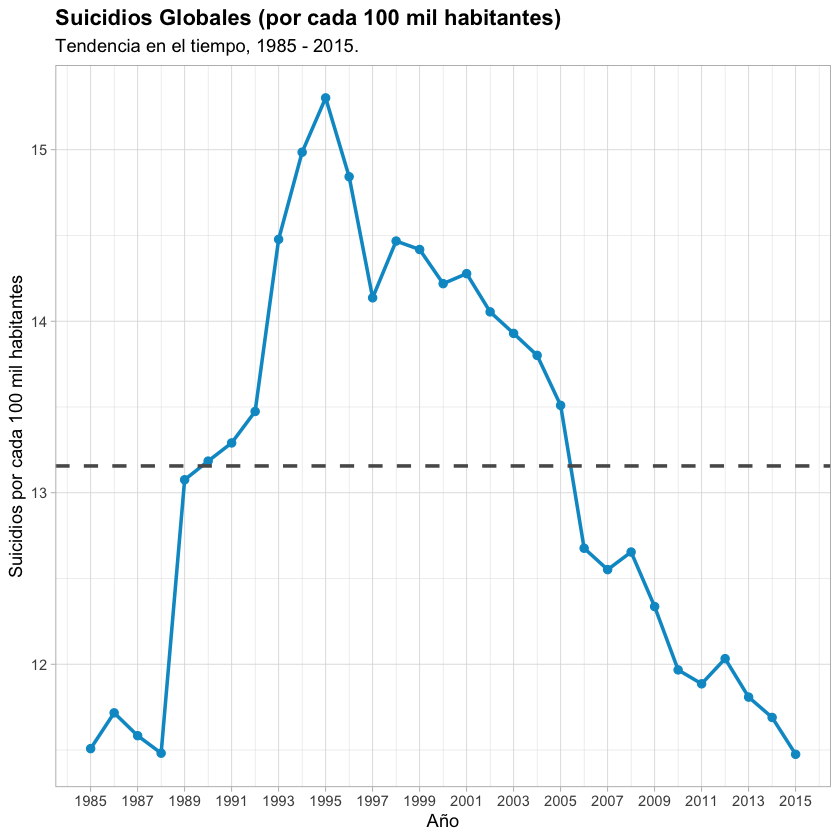

In [30]:
data %>%
  group_by(year) %>%
  summarize(population = sum(population), 
            suicides = sum(suicides_no), 
            suicides_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = year, y = suicides_per_100k)) + 
  geom_line(col = "deepskyblue3", size = 1) + 
  geom_point(col = "deepskyblue3", size = 2) + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Suicidios Globales (por cada 100 mil habitantes)",
       subtitle = "Tendencia en el tiempo, 1985 - 2015.",
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes") +
  theme(plot.title=element_text(face="bold")) +
  scale_x_continuous(breaks = seq(1985, 2015, 2)) + 
  scale_y_continuous(breaks = seq(10, 20))
  ggsave("SG.pdf", width = 20, height = 20, units = "cm")

In [31]:
# Hallazgos:

# La tasa máxima de suicidio fue de 15.3 muertes por cada 100 mil habitantes en 1995
# Disminuyó constantemente, a 11.5 por cada 100 mil habitantes en 2015 (25% de disminución)
# Los índices de suicidio actualmente solo están regresando a sus tasas anteriores de los 90's
# Datos limitados en la década de 1980, por lo que es difícil decir si la tasa era verdaderamente representativa 
##   de la población mundial

### Por Continente

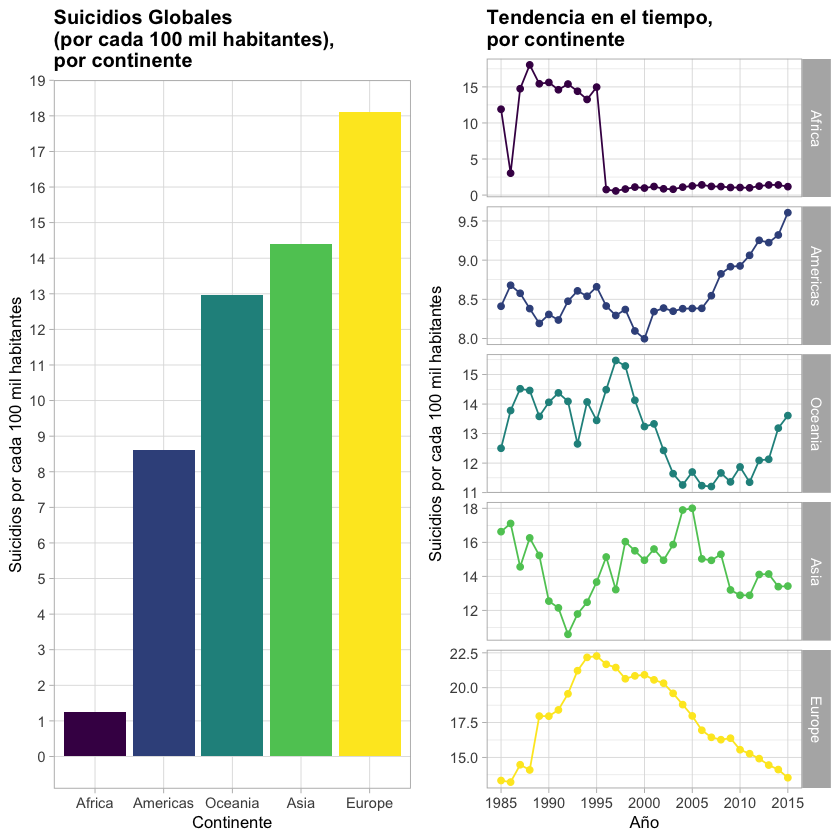

In [32]:
continent <- data %>%
  group_by(continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(suicide_per_100k)

continent$continent <- factor(continent$continent, ordered = T, levels = continent$continent)

continent_plot <- ggplot(continent, aes(x = continent, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Suicidios Globales\n(por cada 100 mil habitantes),\npor continente",
  x = "Continente", 
  y = "Suicidios por cada 100 mil habitantes", 
  fill = "Continent") +
  theme(legend.position = "none", title = element_text(size = 10)) +
  theme(plot.title=element_text(face="bold")) +
  scale_y_continuous(breaks = seq(0, 20, 1), minor_breaks = F)
ggsave("SGC.pdf", width = 20, height = 20, units = "cm")

### Tendencia en el tiempo
continent_time <- data %>%
  group_by(year, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

continent_time$continent <- factor(continent_time$continent, ordered = T, levels = continent$continent)

continent_time_plot <- ggplot(continent_time, aes(x = year, y = suicide_per_100k, col = factor(continent))) + 
  facet_grid(continent ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "Tendencia en el tiempo,\npor continente", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       color = "Continent") + 
  theme(legend.position = "none", title = element_text(size = 10)) +
  theme(plot.title=element_text(face="bold")) +
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)

  grid.arrange(continent_plot, continent_time_plot, ncol = 2)
  ggsave("TC.pdf", width = 20, height = 20, units = "cm")

In [33]:
# Hallazgos:

# La tasa europea es la más alta en general, pero ha disminuido de manera constante en un 40% desde 1995
# La tasa europea para 2015 es similar a Asia y Oceanía
# La línea de tendencia para África se debe a la mala calidad de los datos: solo 3 países han proporcionado datos
# Las tendencias de Oceanía y América son más preocupantes.

### Por Sexo

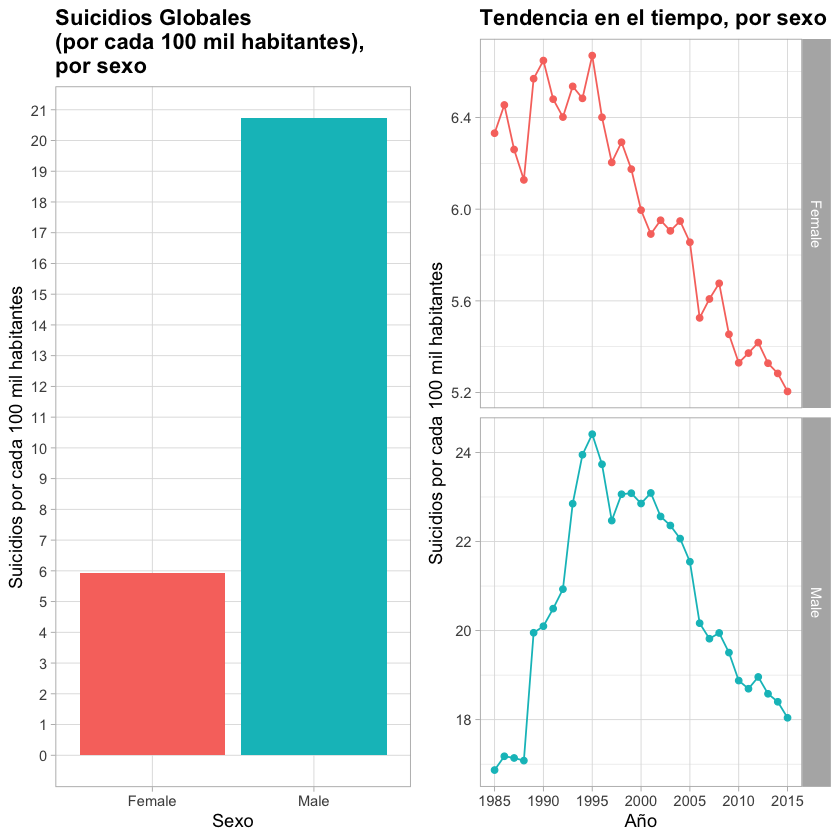

In [34]:
sex_plot <- data %>%
  group_by(sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
ggplot(aes(x = sex, y = suicide_per_100k, fill = sex)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Suicidios Globales\n(por cada 100 mil habitantes),\npor sexo",
       x = "Sexo", 
       y = "Suicidios por cada 100 mil habitantes") +
  theme(legend.position = "none") + 
  theme(plot.title=element_text(face="bold")) +
  scale_y_continuous(breaks = seq(0, 25), minor_breaks = F)
  ggsave("SGS.pdf", width = 20, height = 20, units = "cm")

### Tendencia en el tiempo
sex_time_plot <- data %>%
  group_by(year, sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = factor(sex))) + 
  facet_grid(sex ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "Tendencia en el tiempo, por sexo", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       color = "Sex") + 
  theme(legend.position = "none") + 
  theme(plot.title=element_text(face="bold")) +
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)

  grid.arrange(sex_plot, sex_time_plot, ncol = 2)
  ggsave("TS.pdf", width = 20, height = 20, units = "cm")

In [35]:
# Hallazgos:

# A nivel mundial, la tasa de suicidio para los hombres ha sido ~ 3.5x más alta para los hombres
# Las tasas de suicidio tanto masculinas como femeninas alcanzaron su punto máximo en 1995, 
##   disminuyendo desde entonces.
# Esta relación de 3.5: 1 (hombre: mujer) se ha mantenido relativamente constante desde mediados de los 90's.
# Sin embargo, durante la década de los 80's esta relación era tan baja como 2.7: 1 (hombre: mujer)

### Por Edad

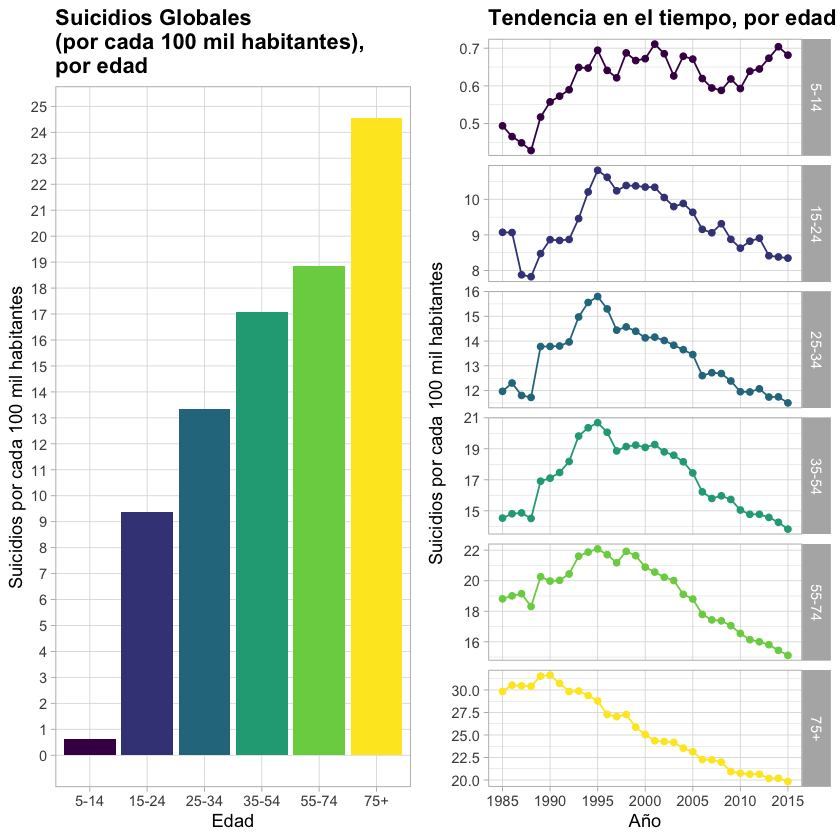

In [36]:
age_plot <- data %>%
  group_by(age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = age, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Suicidios Globales\n(por cada 100 mil habitantes),\npor edad",
       x = "Edad", 
       y = "Suicidios por cada 100 mil habitantes") +
  theme(plot.title=element_text(face="bold")) +
  theme(legend.position = "none") + 
  scale_y_continuous(breaks = seq(0, 30, 1), minor_breaks = F)
  ggsave("SGE.pdf", width = 20, height = 20, units = "cm")

### Tendencia en el tiempo
age_time_plot <- data %>%
  group_by(year, age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = age)) + 
  facet_grid(age ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "Tendencia en el tiempo, por edad", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       color = "Age") + 
  theme(plot.title=element_text(face="bold")) +
  theme(legend.position = "none") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)


  grid.arrange(age_plot, age_time_plot, ncol = 2)
  ggsave("TE.pdf", width = 20, height = 20, units = "cm")

In [37]:
# Hallazgos:

# A nivel mundial, la probabilidad de suicidio aumenta con la edad
# Desde 1995, la tasa de suicidio para todas las personas mayores de 15 años ha disminuido linealmente.
# La tasa de suicidios de los mayores de 75 años ha disminuido en más del 50% desde 1990.
# La tasa de suicidio en la categoría "5-14" sigue siendo aproximadamente estática y pequeña 
##   (<1 por cada 100 mil habitantes por año)

### Por País

### Generalización

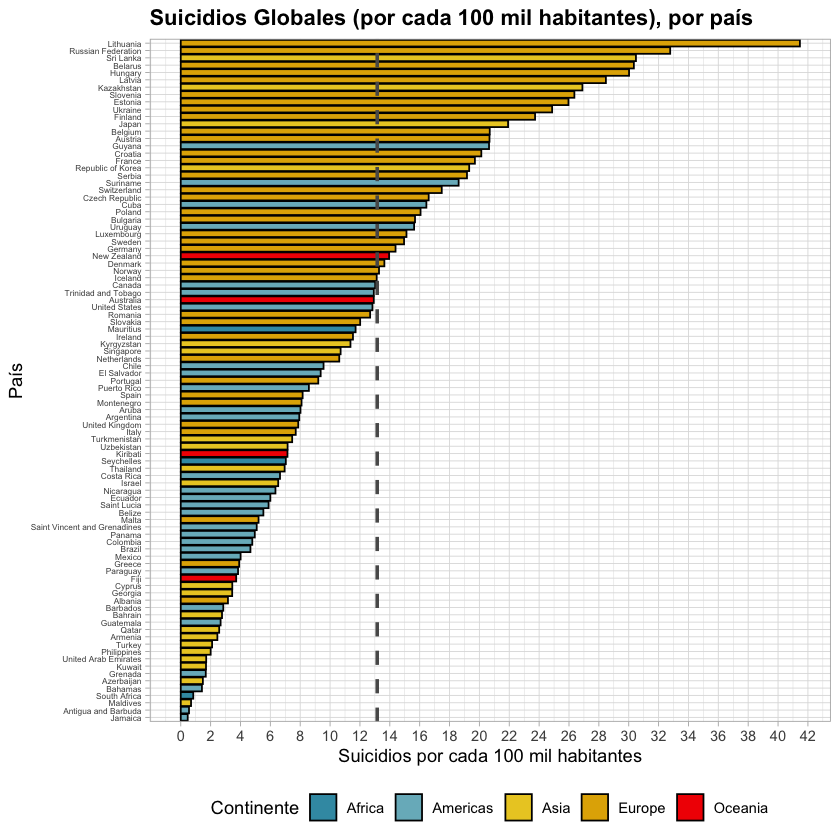

In [38]:
country <- data %>%
  group_by(country, continent) %>%
  summarize(n = n(), 
            suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(desc(suicide_per_100k))

country$country <- factor(country$country, 
                          ordered = T, 
                          levels = rev(country$country))

  ggplot(country, aes(x = country, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity", color="black") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Suicidios Globales (por cada 100 mil habitantes), por país",
       x = "País", 
       y = "Suicidios por cada 100 mil habitantes", 
       fill = "Continente") +
  theme(plot.title=element_text(face="bold")) +
  scale_fill_manual(values = wes_palette("Zissou1", n = 5))+
  coord_flip() +
  theme(axis.text.y = element_text(size=5)) +
  scale_y_continuous(breaks = seq(0, 45, 2)) + 
  theme(legend.position = "bottom") +
  ggsave("SGP.pdf", width = 20, height = 20, units = "cm")

In [39]:
# Hallazgos:

# La tasa de Lituania ha sido más alta por un amplio margen: > 41 suicidios por cada 100 mil personas (por año)
# Gran sobrerrepresentación de países europeos con tasas altas, pocos con tasas bajas

In [40]:
# A continuación se muestra un mapa geográfico de las tasas de suicidios entre los plazos de este análisis; 
# tenga en cuenta la falta de datos para África y Asia, y tenga en cuenta que 7 países se eliminaron 
# debido a la insuficiencia de datos.

92 codes from your data successfully matched countries in the map
1 codes from your data failed to match with a country code in the map
151 codes from the map weren't represented in your data


You asked for 7 categories, 9 were used due to pretty() classification


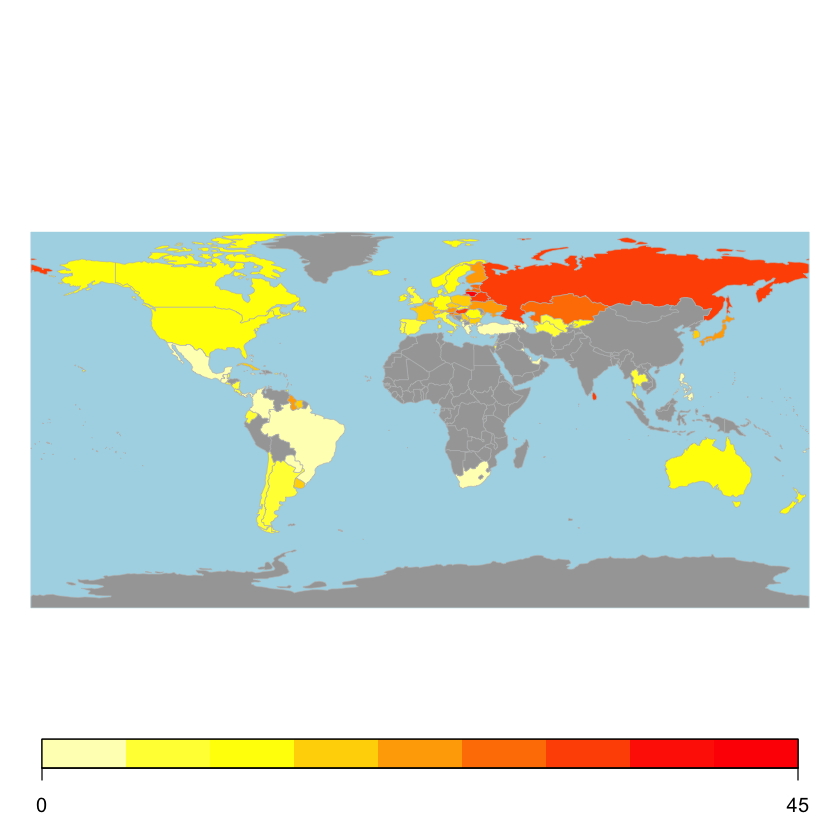

In [41]:
country <- data %>%
  group_by(country) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

countrydata <- joinCountryData2Map(country, joinCode = "NAME", nameJoinColumn = "country")

par(mar=c(0, 0, 0, 0)) # margins

mapCountryData(countrydata, 
nameColumnToPlot="suicide_per_100k", 
mapTitle="", 
colourPalette = "heat", 
oceanCol="lightblue", 
missingCountryCol="grey65", 
catMethod = "pretty")

You asked for 7 categories, 9 were used due to pretty() classification


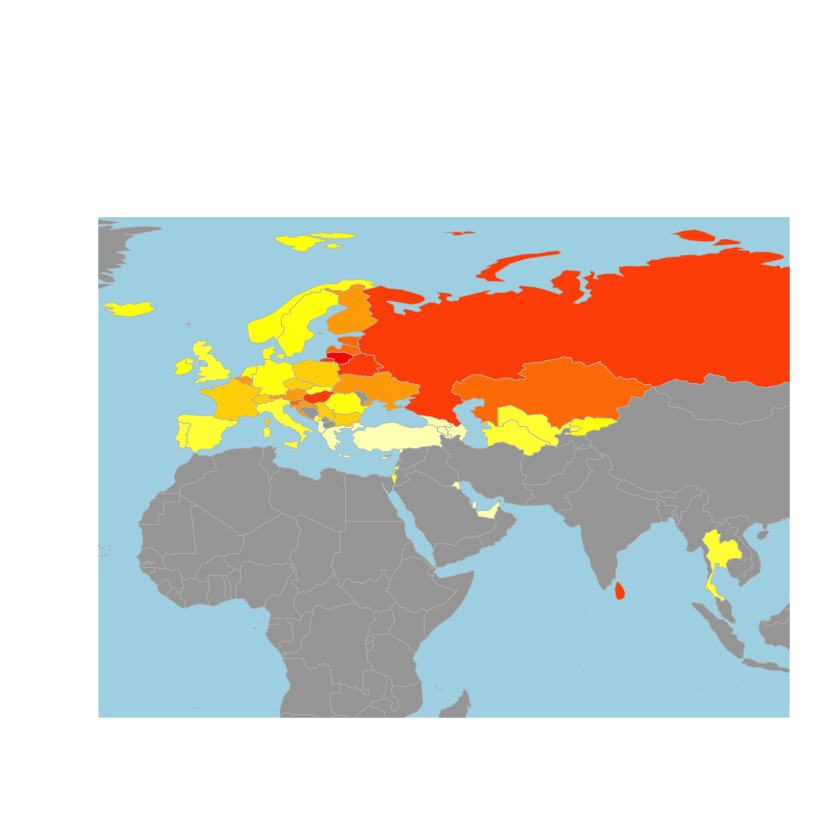

In [42]:
mapCountryData(countrydata, 
nameColumnToPlot="suicide_per_100k", 
mapTitle="", 
mapRegion = "eurasia", 
colourPalette = "heat", 
oceanCol="lightblue", 
missingCountryCol="grey65", 
addLegend = FALSE, 
catMethod = "pretty")

In [43]:
# Es importante tener en cuenta que observar las cifras a nivel global / continente 
# puede no ser verdaderamente representativo del globo / continente por estas razones.

# La comparación de las tasas brutas de suicidio de los países también puede llevar a algunos problemas: 
# la definición de suicidio (y la confiabilidad de que una muerte se registre como suicidio) 
# probablemente variará de un país a otro.

# Sin embargo, es probable que las tendencias a lo largo del tiempo (dentro de los países) sean confiables. 

### Tendencias Lineales

In [44]:
# Es interesante cómo la tasa de suicidio está cambiando con el tiempo dentro de cada país. 
# En lugar de visualizar las tasas de 93 países a lo largo del tiempo, se adaptará una regresión lineal simple 
# a los datos de cada país. Extraer aquellos con un valor de p 'año' 
# (corregido para comparaciones múltiples) de <0.05.

# En otras palabras: a medida que pasa el tiempo, buscar países donde la tasa de suicidios 
# está aumentando o disminuyendo linealmente con el tiempo. Estos pueden ser ordenados 
# por su coeficiente de "año", que sería su tasa de cambio a medida que pasa el tiempo.

In [45]:
country_year <- data %>%
  group_by(country, year) %>%
  summarize(suicides = sum(suicides_no), 
            population = sum(population), 
            suicide_per_100k = (suicides / population) * 100000, 
            gdp_per_capita = mean(gdp_per_capita))


country_year_trends <- country_year %>%
  ungroup() %>%
  nest(-country) %>% # formato: país, resto de datos (en la columna de la lista)
  mutate(model = map(data, ~ lm(suicide_per_100k ~ year, data = .)), # para cada ítem en 'datos', ajuste un modelo lineal
         tidied = map(model, tidy)) %>% # ordenar cada uno de estos en formato de marco de datos - llame a esta lista 'ordenada'
  unnest(tidied)

country_year_sig_trends <- country_year_trends %>%
  filter(term == "year") %>%
  mutate(p.adjusted = p.adjust(p.value, method = "holm")) %>%
  filter(p.adjusted < .05) %>%
  arrange(estimate)

country_year_sig_trends$country <- factor(country_year_sig_trends$country, 
                                          ordered = T, 
                                          levels = country_year_sig_trends$country)

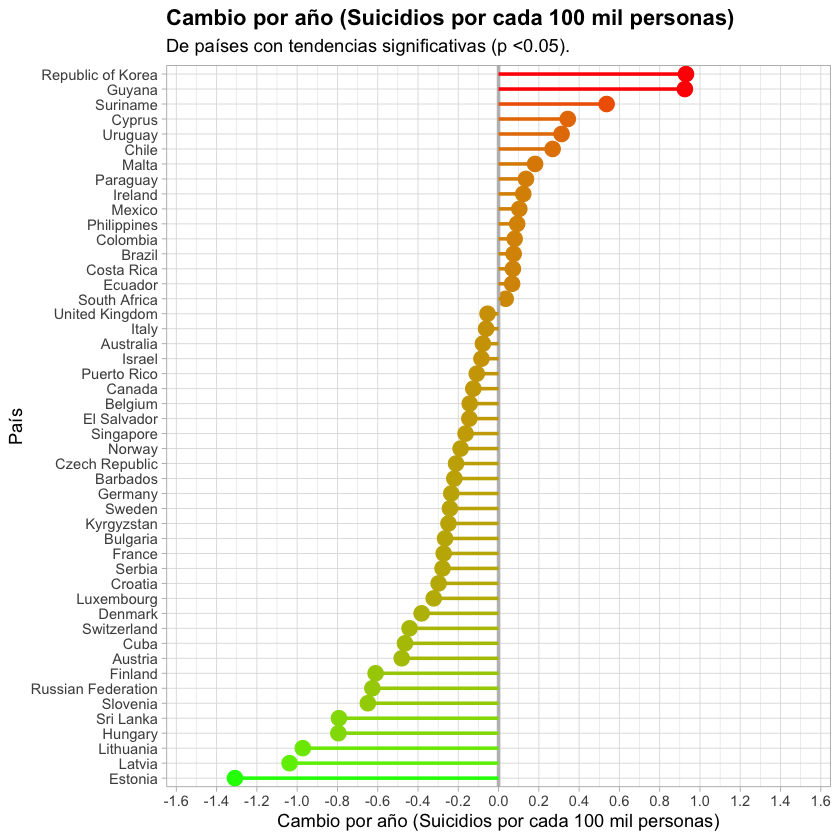

In [46]:
# plot 1
ggplot(country_year_sig_trends, aes(x=country, y=estimate, col = estimate)) + 
  geom_point(stat='identity', size = 4) +
  geom_hline(yintercept = 0, col = "grey", size = 1) +
  scale_color_gradient(low = "green", high = "red") +
  geom_segment(aes(y = 0, 
                   x = country, 
                   yend = estimate, 
                   xend = country), size = 1) +
  labs(title="Cambio por año (Suicidios por cada 100 mil personas)", 
       subtitle="De países con tendencias significativas (p <0.05).", 
       x = "País", y = "Cambio por año (Suicidios por cada 100 mil personas)") +
  theme(plot.title=element_text(face="bold")) +
  scale_y_continuous(breaks = seq(-2, 2, 0.2), limits = c(-1.5, 1.5)) +
  theme(legend.position = "none") +
  coord_flip()

In [47]:
# Hallazgos:
# 1/2 de todos los países las tasas de suicidio están cambiando linealmente a medida que avanza el tiempo
# 32 (2/3) de estos 48 países están disminuyendo
# En general, esto es pintar una imagen positiva.

In [48]:
# Tendencias de aumento más pronunciadas:

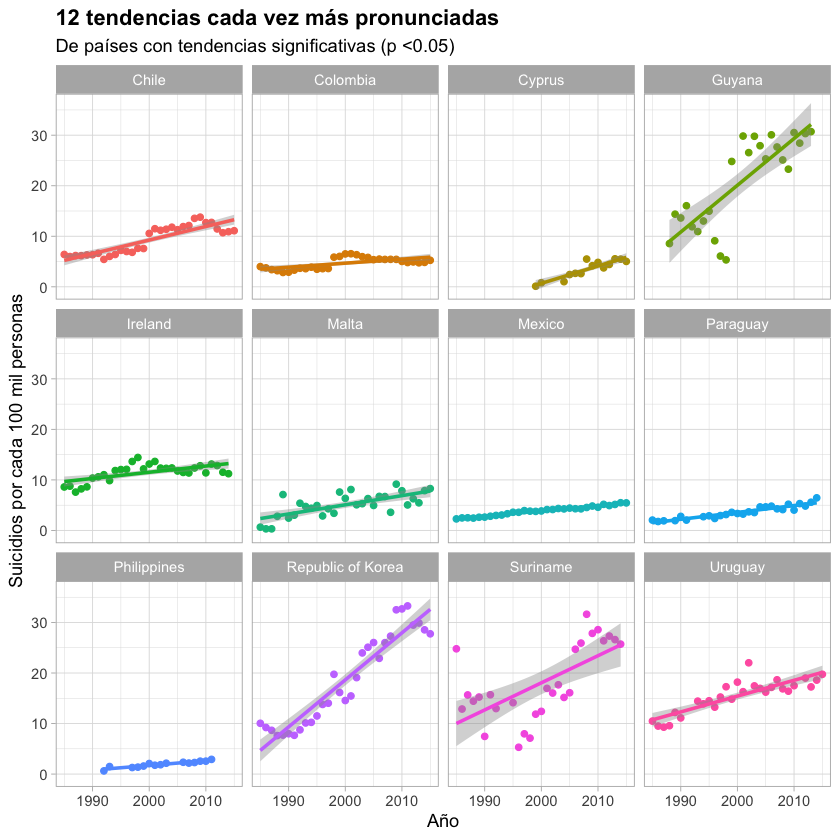

In [49]:
top12_increasing <- tail(country_year_sig_trends$country, 12)

country_year %>%
  filter(country %in% top12_increasing) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point() + 
  geom_smooth(method = "lm") + 
  facet_wrap(~ country) + 
  theme(legend.position = "none") + 
  labs(title="12 tendencias cada vez más pronunciadas", 
       subtitle="De países con tendencias significativas (p <0.05)", 
       x = "Año", 
       y = "Suicidios por cada 100 mil personas") +
  theme(plot.title=element_text(face="bold")) 

In [50]:
# Hallazgos: 

# Corea del Sur muestra la tendencia más preocupante: un aumento en el suicidio de 0.931 personas 
#   (por cada 100 mil por año), el mayor aumento a nivel mundial
# Guyana es similar, con + 0.925 personas (por 100k, por año)
# Entre 1998 y 1999 (5.3 a 24.8), la tasa de Guyana aumentó en ~ 365%
# Los datos históricos de Guyana parecen cuestionables: se sabe que las tasas de suicidio son muy altas, 
# pero el salto parece poco probable (¿tal vez cambió la forma en que clasificaron el suicidio?)

In [51]:
# Tendencias decrecientes más pronunciadas:

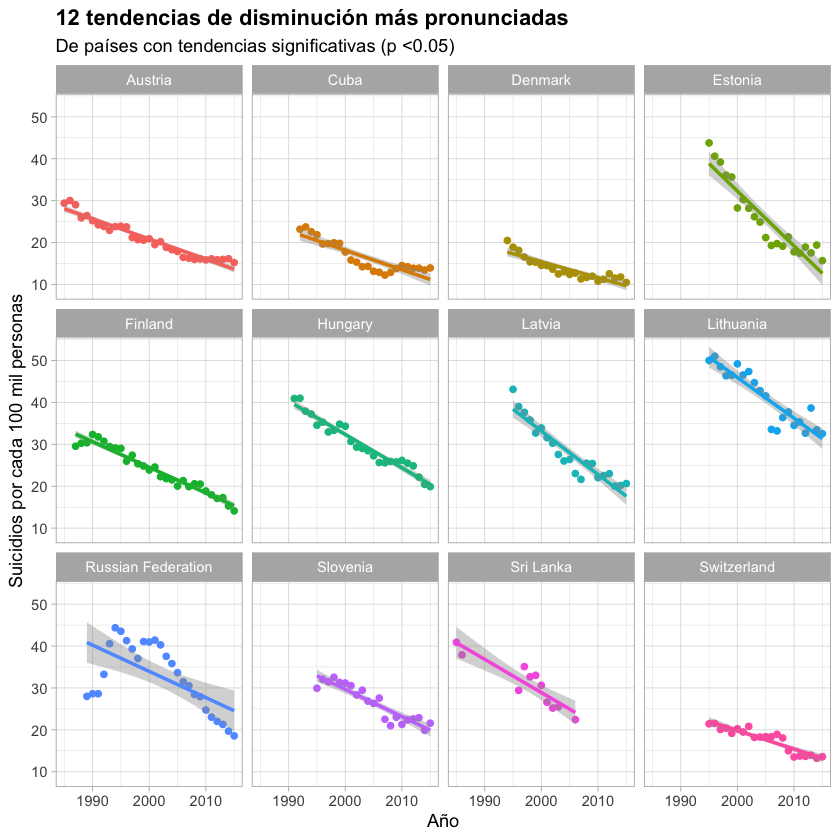

In [52]:
top12_decreasing <- head(country_year_sig_trends$country, 12)

country_year %>%
  filter(country %in% top12_decreasing) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point() + 
  geom_smooth(method = "lm") + 
  facet_wrap(~ country) + 
  theme(legend.position = "none") + 
  labs(title="12 tendencias de disminución más pronunciadas", 
       subtitle="De países con tendencias significativas (p <0.05)", 
       x = "Año", 
       y = "Suicidios por cada 100 mil personas") +
  theme(plot.title=element_text(face="bold")) 

In [53]:
# Hallazgos:

# Estonia muestra la tendencia más positiva: cada año, ~ 1.31 personas menos (por cada 100 mil habitantes) 
#    se suicidan - la mayor disminución a nivel mundial
# Entre 1995 y 2015, esto se reduce de 43.8 a 15.7 por cada 100 mil habitantes (por año), 
#    una disminución del 64%.
# La tendencia de la Federación Rusa es interesante, apenas comenzó a caer en 2002. 
#    Desde entonces, ha disminuido en un ~ 50%.

### Diferencias de género, por continente

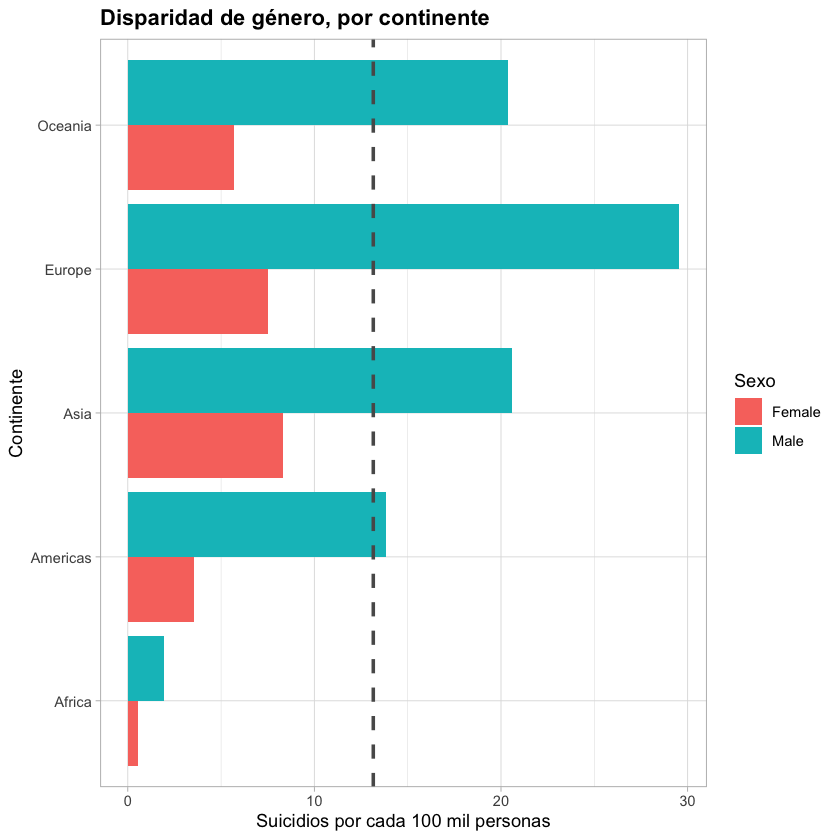

In [54]:
data %>%
  group_by(continent, sex) %>%
  summarize(n = n(), 
            suicides = sum(as.numeric(suicides_no)), 
            population = sum(as.numeric(population)), 
            suicide_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = continent, y = suicide_per_100k, fill = sex)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Disparidad de género, por continente",
   x = "Continente", 
   y = "Suicidios por cada 100 mil personas", 
   fill = "Sexo") +
  theme(plot.title=element_text(face="bold")) +
  coord_flip()

In [55]:
# Hallazgos:

# Los hombres europeos se encontraban en mayor riesgo entre 1985 y 2015, con ~ 30 suicidios 
#    (por cada 100 mil personas, por año)
# Asia tuvo la representación más pequeña del suicidio masculino: la tasa fue de ~ 2.5 veces más alta 
#    para los hombres
# Comparativamente, la tasa de Europa era ~ 3.9x mas alta para los hombres

### Diferencias de género, por país

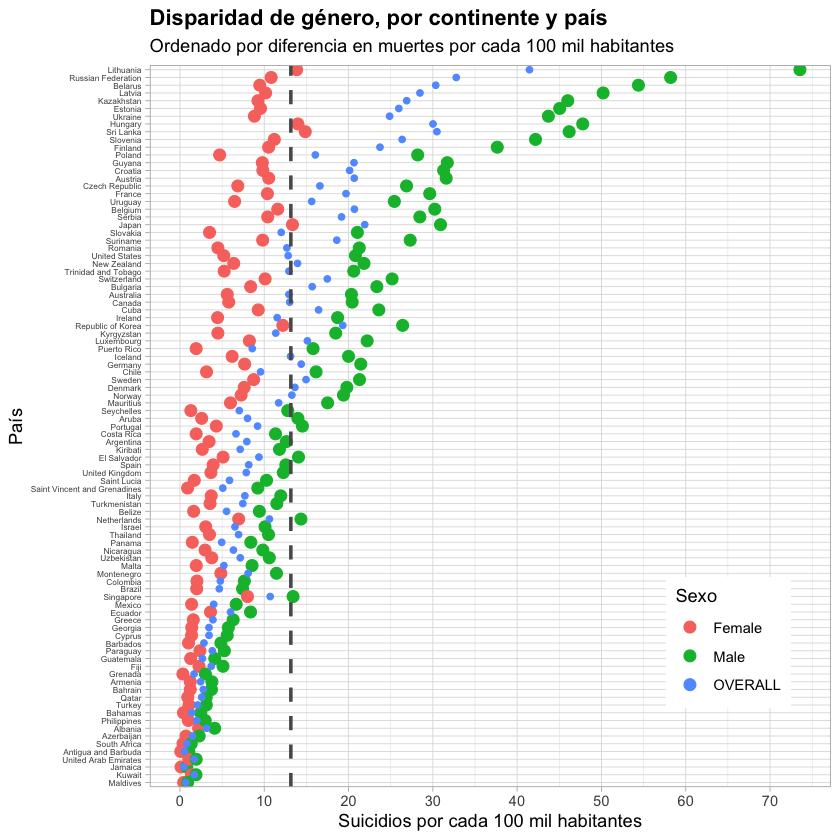

In [56]:
country_long <- data %>%
  group_by(country, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  mutate(sex = "OVERALL")

### por país, continente, sexo

sex_country_long <- data %>%
  group_by(country, continent, sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)


sex_country_wide <- sex_country_long %>%
  spread(sex, suicide_per_100k) %>%
  arrange(Male - Female)


sex_country_wide$country <- factor(sex_country_wide$country, 
                                         ordered = T, 
                                         levels = sex_country_wide$country)

sex_country_long$country <- factor(sex_country_long$country, 
                                   ordered = T, 
                                   levels = sex_country_wide$country) # using the same order



### Este gráfico nos muestra cómo la disparidad entre las muertes varía según el género para cada país
# también tiene la tasa de mortalidad combinada general: en general, los países con una tasa de mortalidad 
## más alta tienen una mayor disparidad
# Esto se debe a que, si el suicidio es más probable en un país, la disparidad entre hombres y mujeres se amplifica

ggplot(sex_country_wide, aes(y = country, color = sex)) + 
  geom_point(data = sex_country_long, aes(x = suicide_per_100k), size = 3) +
  geom_point(data = country_long, aes(x = suicide_per_100k)) + 
  geom_vline(xintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  theme(axis.text.y = element_text(size = 5), 
        legend.position = c(0.85, 0.2)) + 
  scale_x_continuous(breaks = seq(0, 80, 10)) +
  labs(title = "Disparidad de género, por continente y país", 
       subtitle = "Ordenado por diferencia en muertes por cada 100 mil habitantes", 
       x = "Suicidios por cada 100 mil habitantes", 
       y = "País", 
       color = "Sexo") +
theme(plot.title=element_text(face="bold")) 

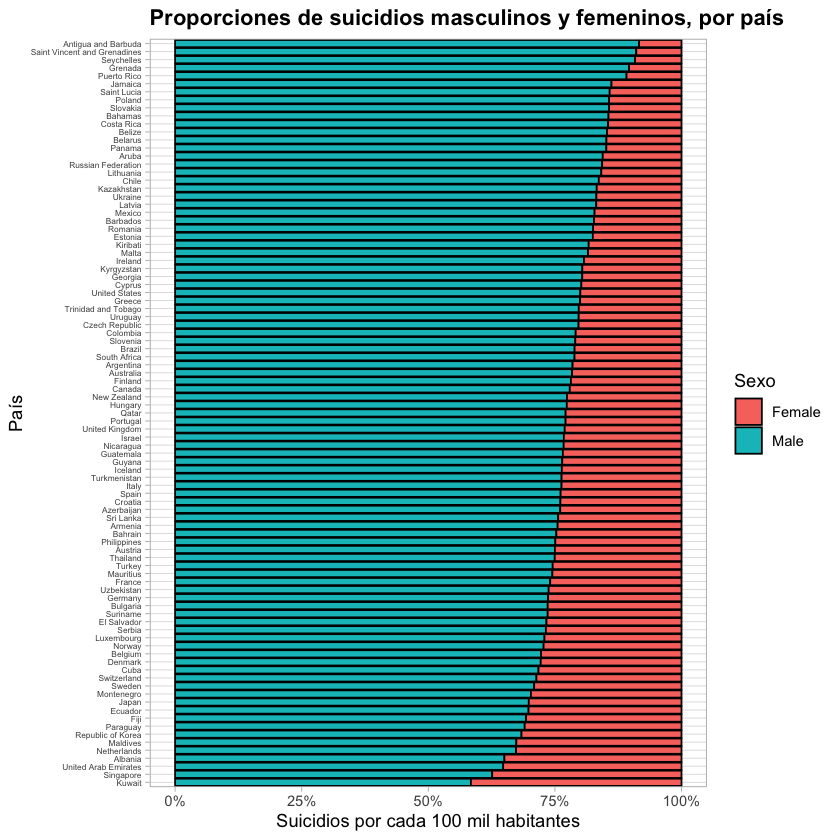

In [57]:
country_gender_prop <- sex_country_wide %>%
  mutate(Male_Proportion = Male / (Female + Male)) %>%
  arrange(Male_Proportion)

sex_country_long$country <- factor(sex_country_long$country, 
                                   ordered = T,
                                   levels = country_gender_prop$country)

ggplot(sex_country_long, aes(y = suicide_per_100k, x = country, fill = sex)) + 
  geom_bar(position = "fill", stat = "identity", color="black") +
  scale_y_continuous(labels = scales::percent) +
  theme(axis.text.y = element_text(size=5)) +
  labs(title = "Proporciones de suicidios masculinos y femeninos, por país", 
       x = "País", 
       y = "Suicidios por cada 100 mil habitantes",
       fill = "Sexo") + 
  theme(plot.title=element_text(face="bold")) +
  coord_flip()

In [58]:
# Hallazgos:

# La representación excesiva de hombres en las muertes por suicidio parece ser universal, y se puede observar 
#   en diferentes grados en cada país.
# Mientras que las mujeres tienen más probabilidades de sufrir depresión y pensamientos suicidas, 
#   los hombres tienen más probabilidades de morir a causa del suicidio. 
#   Esto se conoce como la paradoja de género en el comportamiento suicida.

### Diferencias de edad, por continente

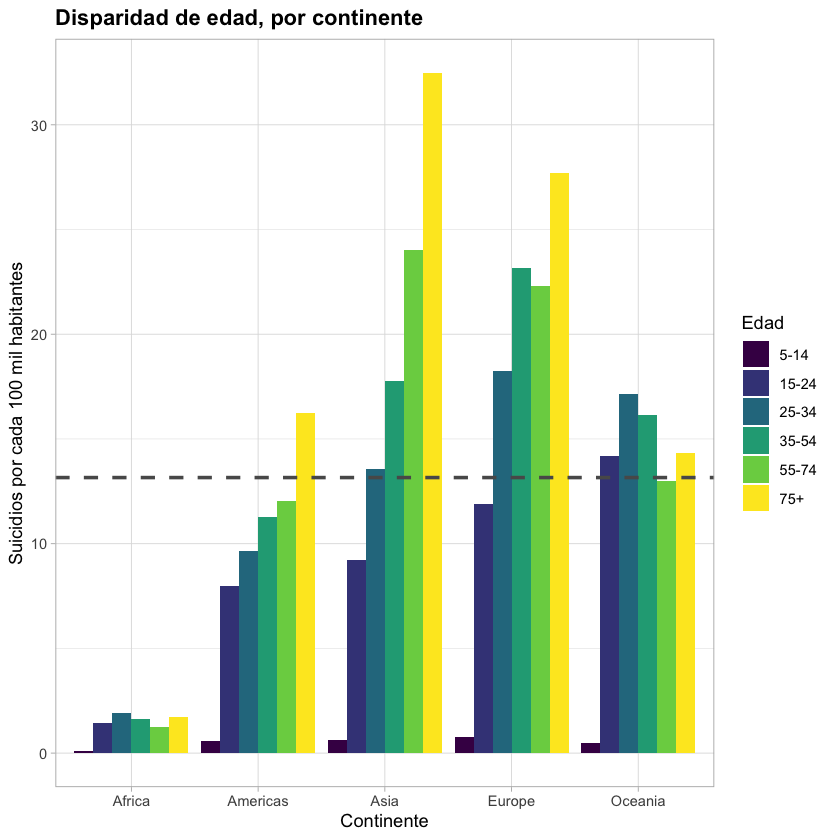

In [59]:
data %>%
  group_by(continent, age) %>%
  summarize(n = n(), 
            suicides = sum(as.numeric(suicides_no)), 
            population = sum(as.numeric(population)), 
            suicide_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = continent, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Disparidad de edad, por continente",
       x = "Continente", 
       y = "Suicidios por cada 100 mil habitantes", 
       fill = "Edad") +
  theme(plot.title=element_text(face="bold")) 

In [60]:
# Hallazgos:

# Para América, Asia y Europa (que constituyen la mayor parte del conjunto de datos), 
#   la tasa de suicidios aumenta con la edad
# Las tarifas de Oceanía y África son más altas para las personas de 25 a 34 años.

### A medida que un país se enriquece, ¿disminuye la tasa de suicidios?

In [61]:
# Depende del país; para casi todos los países, existe una alta correlación entre el año y el PIB per cápita,
#    es decir, a medida que pasa el tiempo, el PIB per cápita aumenta linealmente.

In [62]:
country_year_gdp <- data %>%
  group_by(country, year) %>%
  summarize(gdp_per_capita = mean(gdp_per_capita))
  
country_year_gdp_corr <- country_year_gdp %>%
  ungroup() %>%
  group_by(country) %>%
  summarize(year_gdp_correlation = cor(year, gdp_per_capita))
summary(country_year_gdp_corr)

                country   year_gdp_correlation
 Albania            : 1   Min.   :-0.5458     
 Antigua and Barbuda: 1   1st Qu.: 0.8665     
 Argentina          : 1   Median : 0.9104     
 Armenia            : 1   Mean   : 0.8781     
 Aruba              : 1   3rd Qu.: 0.9552     
 Australia          : 1   Max.   : 0.9969     
 (Other)            :87                       

In [63]:
# Calculando las correlaciones de Pearson entre "año" y "PIB per cápita" dentro de cada país, 
#   se llegó a los siguientes resultados:

# La correlación media fue de 0,878, lo que indica una relación lineal positiva muy fuerte.

# Básicamente, esto significa que mirar dentro de un país y preguntar 
# "si un aumento en el tiempo (por persona) tiene un efecto en la tasa de suicidio" es bastante similar
#  a preguntar "si la tasa de suicidio de un país aumenta a medida que avanza el tiempo".

# Esto fue respondido anteriormente - ¡Depende del país! Algunos países están aumentando con el tiempo,
# la mayoría están disminuyendo.

# En su lugar, se hace una pregunta ligeramente diferente a continuación.

### ¿Los países más ricos tienen una tasa más alta de suicidio?

In [64]:
# En lugar de mirar las tendencias dentro de los países, aquí se toman todos los países 
# y se calcula su PIB promedio (per cápita) a lo largo de todos los años en que se dispone de datos.
# Luego se mide cómo se relaciona esto con la tasa de suicidio de los países en todos esos años.

# El resultado final es un punto de datos por país, destinado a dar una idea general de la riqueza de un país 
# y su tasa de suicidio.

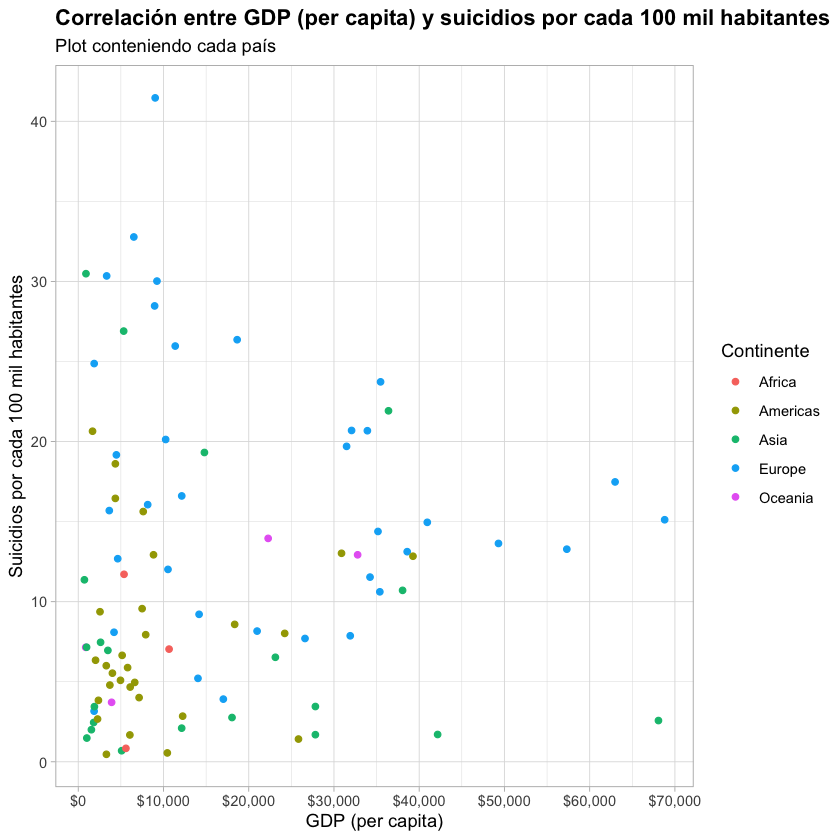

In [65]:
country_mean_gdp <- data %>%
  group_by(country, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000, 
            gdp_per_capita = mean(gdp_per_capita))

ggplot(country_mean_gdp, aes(x = gdp_per_capita, y = suicide_per_100k, col = continent)) + 
  geom_point() + 
  scale_x_continuous(labels=scales::dollar_format(prefix="$"), breaks = seq(0, 70000, 10000)) + 
  labs(title = "Correlación entre GDP (per capita) y suicidios por cada 100 mil habitantes", 
       subtitle = "Plot conteniendo cada país",
       x = "GDP (per capita)", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "Continente") +
  theme(plot.title=element_text(face="bold")) 

In [66]:
# Hay bastantes países con alto apalancamiento y residuos que podrían tener un impacto significativo en el ajuste 
# de la línea de regresión (por ejemplo, Lituania, arriba a la izquierda). Se identificaran y excluiran 
# usando Cooks Distance, excluyendo aquellos países con un valor de CooksD mayor a 4 / n.

# Se evalua las estadísticas de este modelo (con los valores atípicos eliminados) a continuación.

In [67]:
model1 <- lm(suicide_per_100k ~ gdp_per_capita, data = country_mean_gdp)

gdp_suicide_no_outliers <- model1 %>%
  augment() %>%
  arrange(desc(.cooksd)) %>%
  filter(.cooksd < 4/nrow(.)) %>% # eliminado (5/93 en total) de paises
  inner_join(country_mean_gdp, by = c("suicide_per_100k", "gdp_per_capita")) %>%
  select(country, continent, gdp_per_capita, suicide_per_100k)

model2 <- lm(suicide_per_100k ~ gdp_per_capita, data = gdp_suicide_no_outliers)

summary(model2)


Call:
lm(formula = suicide_per_100k ~ gdp_per_capita, data = gdp_suicide_no_outliers)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.769  -5.145  -1.724   3.227  20.221 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.772e+00  1.119e+00   7.839 1.12e-11 ***
gdp_per_capita 1.115e-04  5.015e-05   2.223   0.0288 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.331 on 86 degrees of freedom
Multiple R-squared:  0.05436,	Adjusted R-squared:  0.04337 
F-statistic: 4.944 on 1 and 86 DF,  p-value: 0.02881


In [68]:
# El valor p del modelo es 0.0288 <0.05. Esto significa que podemos rechazar la hipótesis 
#    de que el PIB de un país (per cápita) no tiene asociación con la tasa de suicidio (por cada 100 mil habitantes).

# El r cuadrado es 0.0544, por lo que el PIB (per cápita) explica muy poco 
#    de la variación en la tasa de suicidio en general.

# ¿Qué significa todo esto?

# Existe una relación lineal positiva débil pero significativa: los países más ricos 
#    están asociados con tasas más altas de suicidio, pero esta es una relación débil 

### La razón por la que la variable generación no es usada

In [69]:
# Con datos continuos, si alguien tiene la edad en un año determinado, tiene su generación. 
# La siguiente gráfica muestra cómo funciona esto para este conjunto de datos realmente bien, 
# y es equivalente a la gráfica de edad en el tiempo.

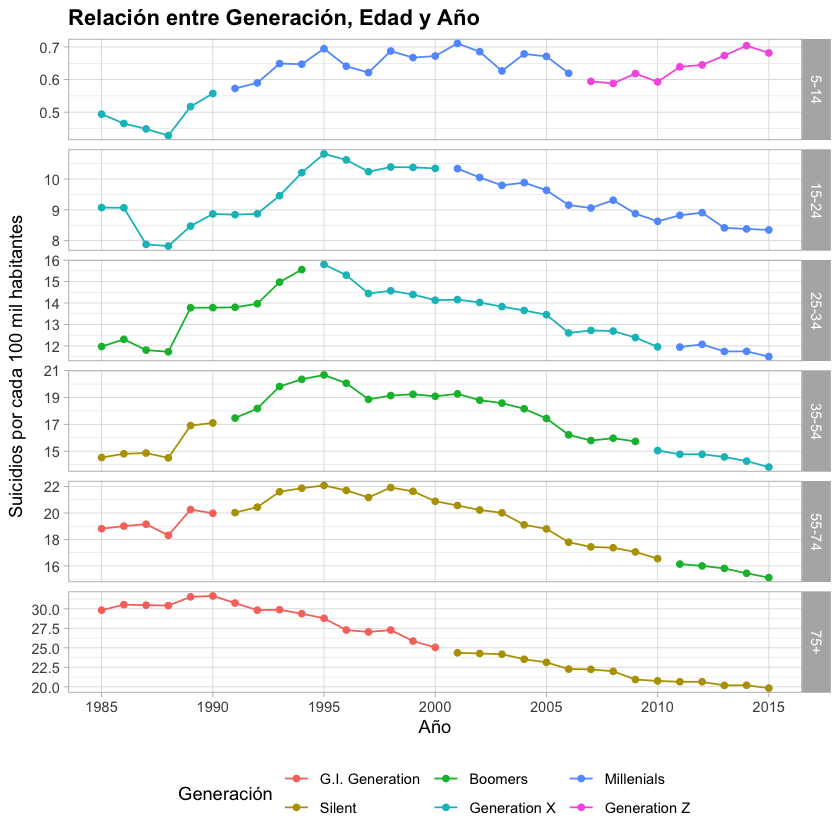

In [70]:
data %>%
  group_by(generation, age, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = factor(generation, ordered = F))) + 
  geom_point() + 
  geom_line() + 
  facet_grid(age ~ ., scales = "free_y") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = NULL) +
  labs(title = "Relación entre Generación, Edad y Año", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "Generación") + 
  theme(legend.position = "bottom") +
  theme(plot.title=element_text(face="bold")) 

In [71]:
# Sin embargo, debido a la superposición de diferentes categorías de edad, tratar de interpretar la tendencia 
#   de las tasas de suicidio de generación en el tiempo crea problemas.

# Compare las tasas a continuación con la gráfica de arriba: los picos grandes se producen al mismo tiempo 
#   que las diferentes bandas de edad comienzan a dejar de clasificarse como de una generación determinada.

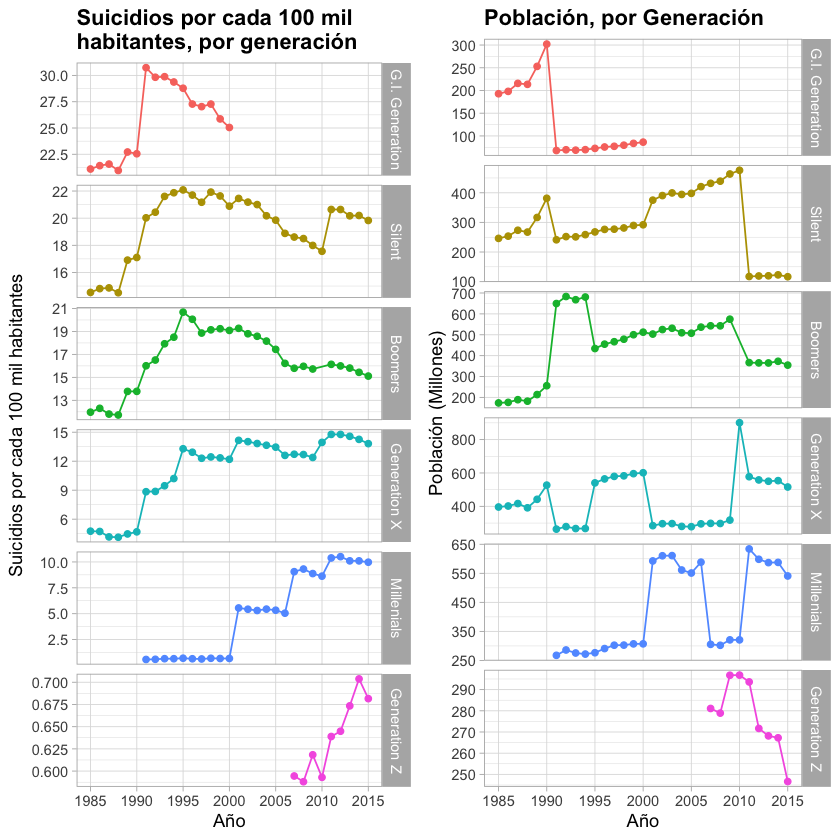

In [72]:
generation_rate <- data %>%
  group_by(generation, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = factor(generation, ordered = F))) + 
  geom_point() + 
  geom_line() + 
  facet_grid(generation ~ ., scales = "free_y") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = NULL) +
  labs(title = "Suicidios por cada 100 mil\nhabitantes, por generación", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes") + 
  theme(plot.title=element_text(face="bold")) +
  theme(legend.position = "none")

generation_population <- data %>%
  group_by(generation, year) %>%
  summarize(population = sum(as.numeric(population))) %>%
  ggplot(aes(x = year, y = population / 1000000, col = factor(generation, ordered = F))) + 
  geom_point() + 
  geom_line() + 
  facet_grid(generation ~ ., scales = "free_y") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = NULL) +
  labs(title = "Población, por Generación", 
       x = "Año", 
       y = "Población (Millones)", 
       col = "Generación") + 
  theme(plot.title=element_text(face="bold")) +
  theme(legend.position = "none")

grid.arrange(generation_rate, generation_population, ncol = 2)

In [73]:
# Probablemente este es un problema con la forma en que se creó el conjunto de datos: 
# parece que la variable de generación se creó después de que los datos se resumieron (por país, año, edad, sexo) 
# y se agregaron al final. Esto no debería ser posible, ya que no todas las personas en un grupo de edad y año 
# determinado serán de una generación.

# Esto muestra por qué los "picos" en la generación a lo largo del tiempo no tienen ningún significado 
# y recomendaría a otros que no usen la variable, ya que puede llevar a conclusiones erróneas.

### El 5% de instancias de mayor riesgo en la historia

In [74]:
# Se filtrarán los datos de 1985 y se observará lo que sucede en las 3 décadas siguientes.

# Es de interés la demografía del 5% de mayor riesgo (suicidios por cada 100 mil habitantes) entre 1986 y 2015.

# Se define una demografía como un año en un país en particular, para una combinación de sexo y edad. 

# Para que un grupo demográfico se encuentre en el 5% superior en cuanto a tasas históricas de suicidio, 
# se requeriría una tasa de suicidio que supere los 50.7 (por cada 100 mil habitantes) en ese año.

In [75]:
demographic_most <- data %>%
  mutate(suicides_per_100k = suicides_no * 100000 / population) %>%
  arrange(desc(suicides_per_100k)) %>% 
  filter(year != 1985) %>%
  head(n = round(nrow(.) * 5 / 100))
  

demographic_most$time <- ifelse(demographic_most$year <= 1995, "1986 - 1995", 
                                ifelse(demographic_most$year <= 2005, "1996 - 2005", 
                                       "2006 - 2015"))

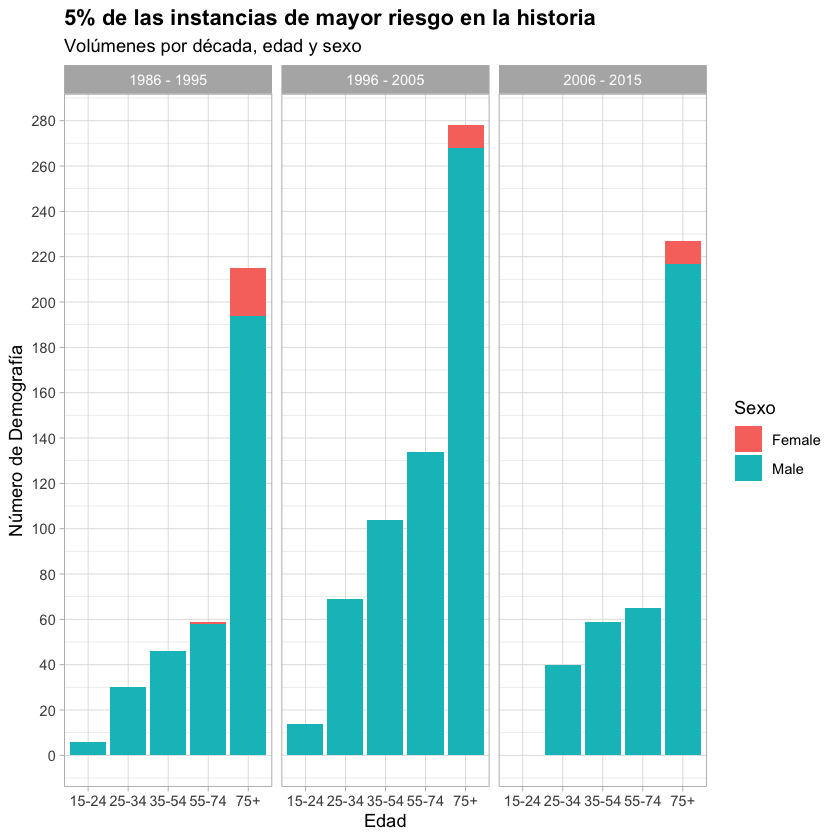

In [76]:
ggplot(demographic_most, aes(x = age, fill = sex)) + 
  geom_bar() + 
  labs(title = "5% de las instancias de mayor riesgo en la historia", 
       subtitle = "Volúmenes por década, edad y sexo",
       x = "Edad", 
       y = "Número de Demografía", 
       fill = "Sexo") +
  theme(plot.title=element_text(face="bold")) +
  facet_wrap(~ time) + 
  scale_y_continuous(breaks = seq(0, 300, 20))

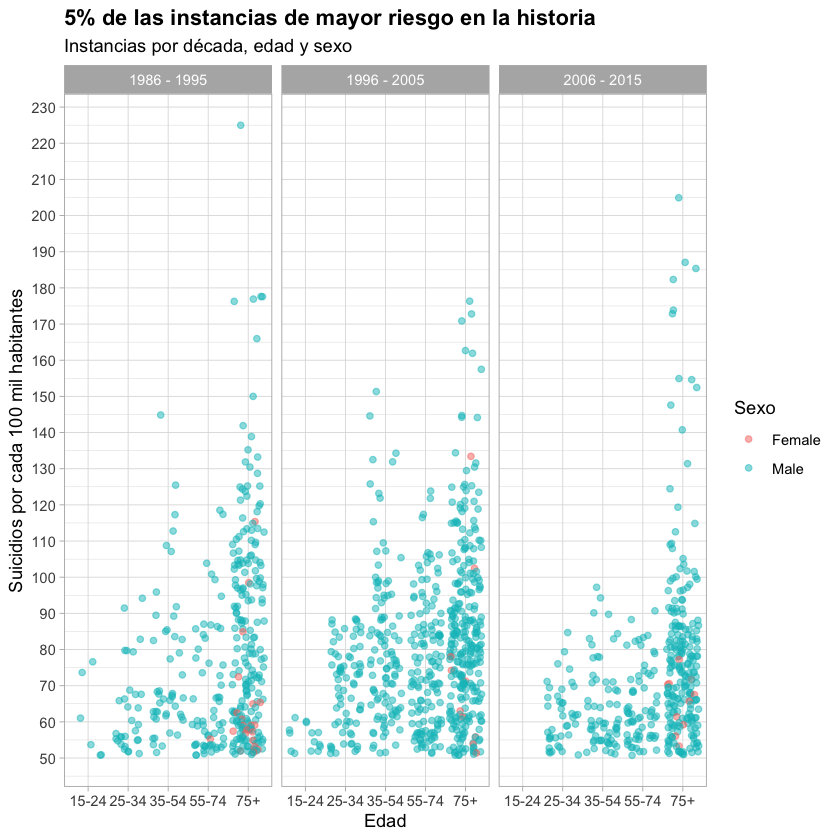

In [77]:
set.seed(1)

ggplot(demographic_most, aes(x = age, y = suicides_per_100k, col = sex)) + 
  geom_jitter(alpha = 0.5) + 
  labs(title = "5% de las instancias de mayor riesgo en la historia", 
       subtitle = "Instancias por década, edad y sexo",
       x = "Edad", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "Sexo") + 
  theme(plot.title=element_text(face="bold")) +
  facet_wrap(~ time) + 
  scale_y_continuous(breaks = seq(50, 300, 10))

In [78]:
# Hallazgos:

# El 44,5% de estas instancias de "alto riesgo" ocurrieron entre 1996 y 2005
# 53.5% estaban en la categoría de edad 75+
# El 96.9% era demográfico masculino.
# Dos de los datos demográficos con mayor riesgo parecen ser hombres en Corea del Sur y Hungría

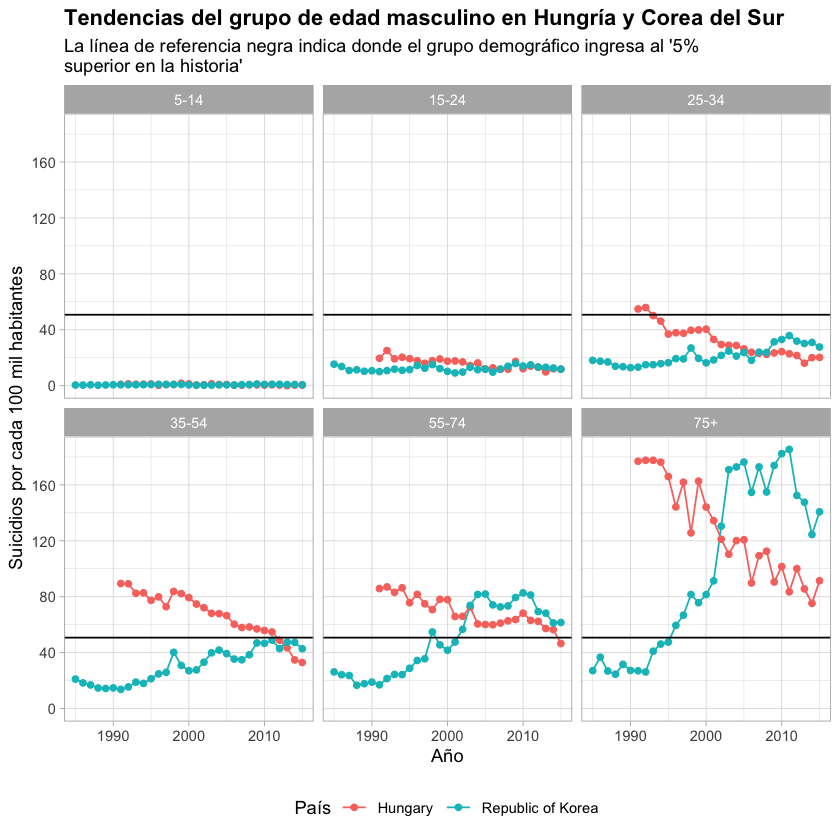

In [79]:
data %>%
  filter(country %in% c('Republic of Korea', 'Hungary'), sex == "Male") %>%
  group_by(country, age, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_line() + 
  geom_point() + 
  facet_wrap(~ age) + 
  geom_hline(yintercept = min(demographic_most$suicides_per_100k)) + 
  theme(legend.position = "bottom") + 
  scale_y_continuous(breaks = seq(0, 220, 40)) +
  labs(title = "Tendencias del grupo de edad masculino en Hungría y Corea del Sur", 
       subtitle = "La línea de referencia negra indica donde el grupo demográfico ingresa al '5%\nsuperior en la historia'",
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes",
       col = "País") +
  theme(plot.title=element_text(face="bold")) 

In [80]:
# Surgen dos tendencias muy diferentes. Hungría obviamente se está moviendo en una dirección positiva, 
# mientras que Corea del Sur parece estar saliendo de una crisis.

# Para Corea del Sur, las tasas de hombres en la categoría 75+ aumentaron de 26.2 (por cada 100 mil habitantes) 
# en 1992, a un máximo de 185 (por cada 100 mil habitantes) en 2011, un aumento de más del 600%. 
# Los hombres de 55-74 años ven un aumento similar.

# Esto se destacó en el análisis estadístico, que identificó a Corea del Sur como el país 
# con mayor crecimiento y a Hungría como el cuarto país con la mayor disminución en general.

### Comparando México, Colombia, Filipinas

In [81]:
# Creo que sería útil comparar algunos países donde las personas se podrían considerar similares a México
# (cultural, legal, económicamente).

### Tendencia general

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1991.9”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5.095”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.389”

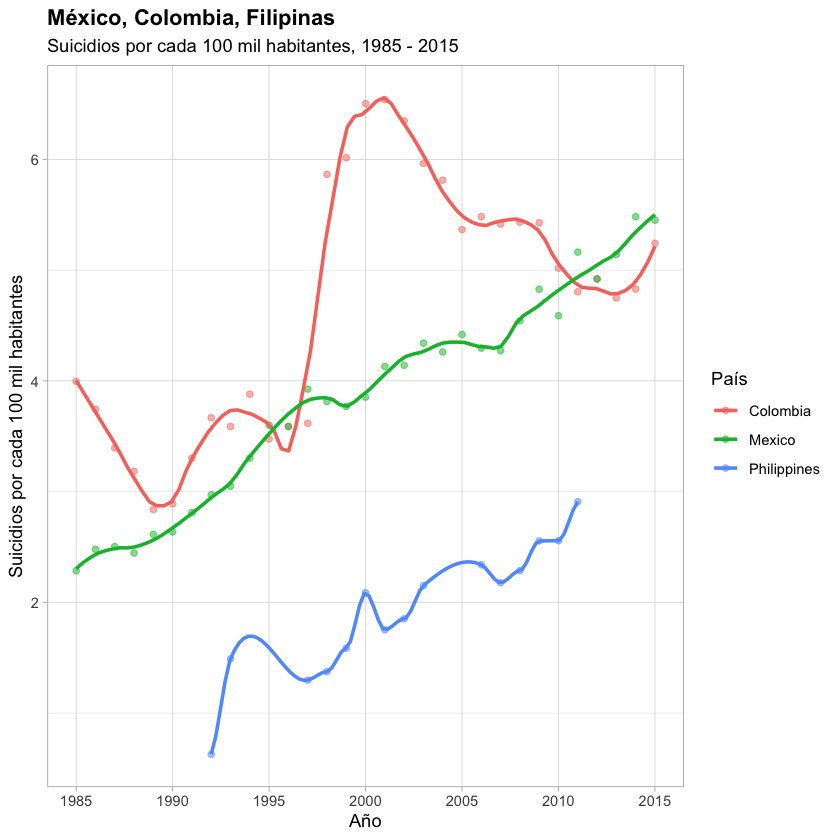

In [82]:
data_filtered <- data %>%
  filter(country %in% c("Mexico", 
                        "Colombia",
                        "Philippines")) 


data_filtered %>%
  group_by(country, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(se = F, span = 0.2) + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F) + 
  labs(title = "México, Colombia, Filipinas", 
       subtitle = "Suicidios por cada 100 mil habitantes, 1985 - 2015", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "País") +
  theme(plot.title=element_text(face="bold")) 

In [83]:
# Hallazgos:

# La tasa de suicidios en México es la tendencia más preocupante, desde 1985 no ha parado de crecer.
# Se estima un incremento del 150%.

# La tasa de suicidios en Colombia es la más interesante. En 1995 - 2000 presentó un incremento del 50%.
# Desde entonces ha disminuido, aunque vuelve a tener una tendencia de crecimiento en el 2015.

# Filipinas cuenta con datos a partir de la decada de 1990, desde entonces ha ido en aumento. Actualmente
# no se puede hacer un analisis de los datos, pues no contamos con registros

### Por Sexo

### Tasas masculinas y femeninas (en el tiempo)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1991.9”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5.095”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.389”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1991.9”Warning message i

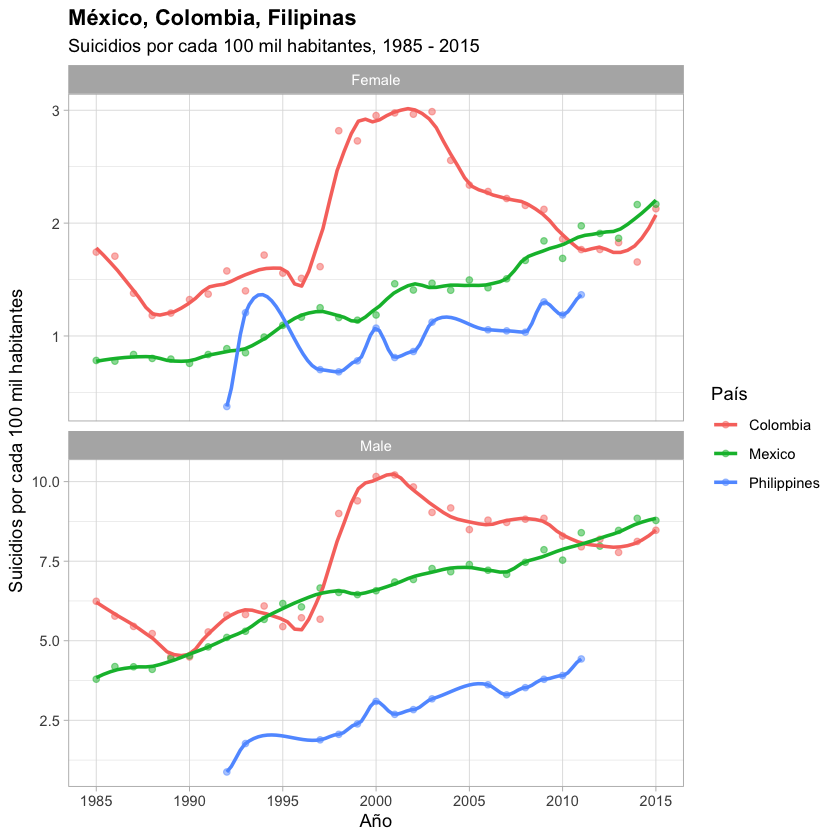

In [84]:
data_filtered %>%
  group_by(country, sex, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(se = F, span = 0.2) + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F) + 
  facet_wrap(~ sex, scales = "free_y", nrow = 2) +
  labs(title = "México, Colombia, Filipinas", 
       subtitle = "Suicidios por cada 100 mil habitantes, 1985 - 2015", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "País") +
  theme(plot.title=element_text(face="bold")) 

In [85]:
# Hallazgos:

# La tasa de suicidios en el año 2000 en Colombia para los hombres, es 3 veces mayor al de las mujeres

# En México mantiene el estandard de suicidios 3.5 veces mayor de hombres al de mujeres.

# Las mujeres en Filipinas muestran una tendencia cambiante, pero siempre apuntando a mayor.

### 2010 - 2015 solamente

In [86]:
# Dado los efectos de estas visualizaciones, es realmente interesante analizar los datos de los últimos años 
# por lo que se restringirá el período de tiempo a partir de 2010.

### Proporción de suicidios de hombres

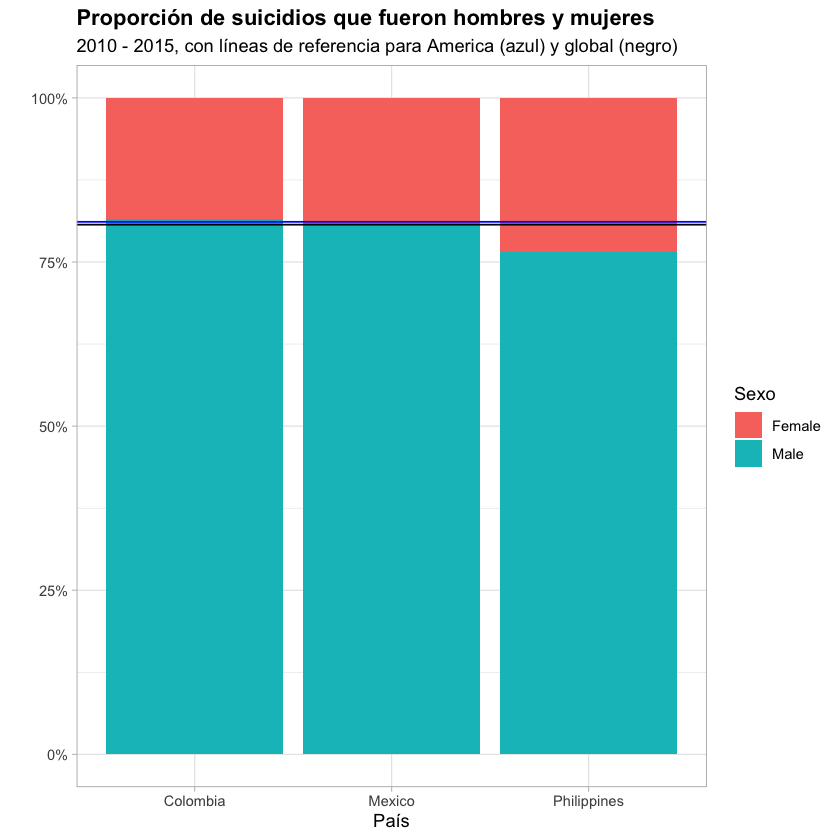

In [88]:
t1 <- data_filtered %>%
  filter(year >= 2010) %>%
  group_by(sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

global_male_proportion <- t1$suicide_per_100k[2] / sum(t1$suicide_per_100k)


t2 <- data_filtered %>%
  filter(year >= 2010, continent == "Americas") %>%
  group_by(sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

americas_male_proportion <- t2$suicide_per_100k[2] / sum(t2$suicide_per_100k)


data_filtered %>%
  filter(year >= 2010) %>%
  group_by(country, sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = country, y = suicide_per_100k, fill = sex)) + 
  geom_bar(position = "fill", stat = "identity") + 
  geom_hline(yintercept = global_male_proportion) + 
  geom_hline(yintercept = americas_male_proportion, col = "blue") + 
  scale_y_continuous(labels = scales::percent) + 
  labs(title = "Proporción de suicidios que fueron hombres y mujeres", 
       subtitle = "2010 - 2015, con líneas de referencia para America (azul) y global (negro)", 
       x = "País", 
       y = "", 
       fill = "Sexo") +
  theme(plot.title=element_text(face="bold")) 

In [89]:
# Hallazgos:

# Analizar Filipinas podria llevarnos a un analisis erroneo, pues solo contamos con un año de registros a partir
# del 2010

# Mexico y Colombia se muestra apegado a los indices Globales y de America. 

### Tasas de edad

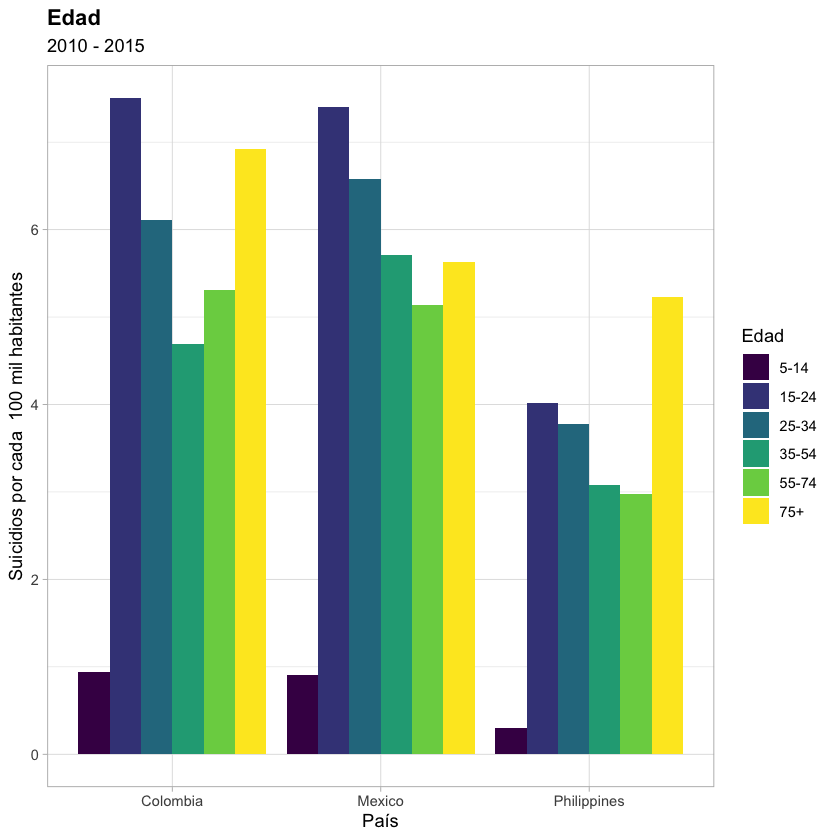

In [90]:
data_filtered %>%
  filter(year >= 2010) %>%
  group_by(country, age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = country, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  labs(title = "Edad ", 
       subtitle = "2010 - 2015", 
       x = "País", 
       y = "Suicidios por cada  100 mil habitantes", 
       fill = "Edad") +
  theme(plot.title=element_text(face="bold")) 

In [91]:
# Hallazgos:

# Analizar Filipinas podria llevarnos a un analisis erroneo, por lo tanto no se toma en cuenta.

# Los que tienen entre 15 y 24 años corren el mayor riesgo en México y Colombia

# La tasa de suicidios en México parece disminuir con la edad

# Colombia muestra indices de suicidios altos en sus extremos (15-24) y (75+)

### Tasas masculinas y femeninas (para diferentes categorías de edad)

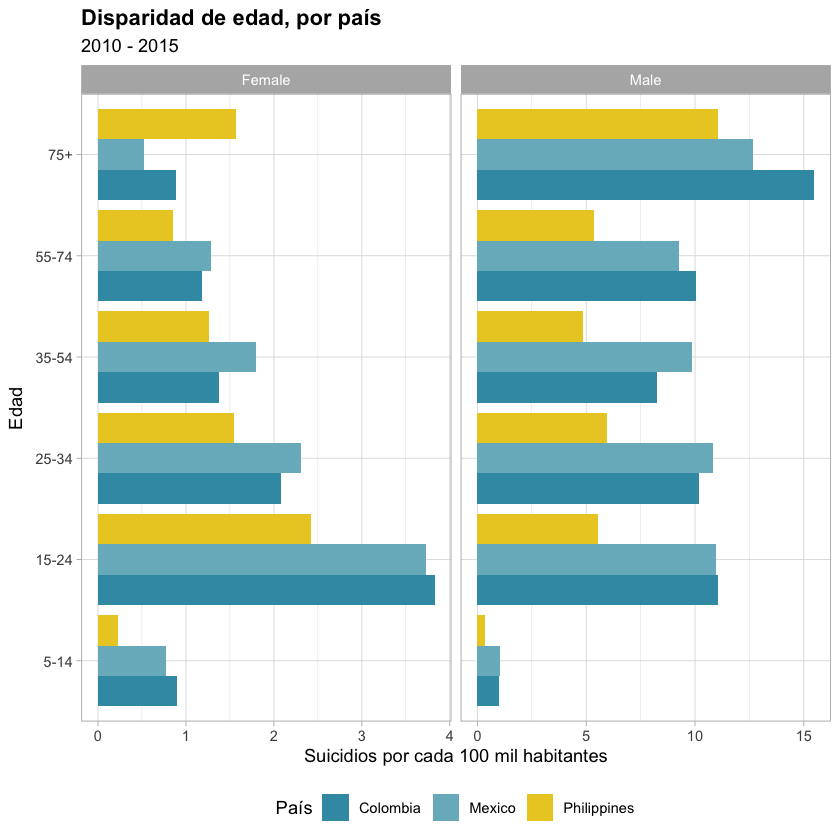

In [92]:
data_filtered %>% 
  filter(year >= 2010) %>%
  group_by(country, sex, age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = age, y = suicide_per_100k, fill = country)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  facet_wrap(~ sex, scales = "free_x") +
  labs(title = "Disparidad de edad, por país",
       subtitle = "2010 - 2015",
       x = "Edad", 
       y = "Suicidios por cada 100 mil habitantes", 
       fill = "País") +
  theme(plot.title=element_text(face="bold")) +
  scale_fill_manual(values = wes_palette("Zissou1", n = 5)) +
  coord_flip() + 
  theme(legend.position = "bottom")

In [93]:
# Hallazgos:

# Nuevamente se ignoran los registros de Filipinas

# Se puede observar que la disparidad por edad en México y Colombia es muy similar

### Jóvenes -> hombres de mediana edad

In [94]:
#Existe una gran preocupación en México con respecto a los problemas de salud mental y el suicidio 
# para hombres jóvenes y de mediana edad. Aquí se va a restringir el análisis a solo:

#     Hombres
#     Edades “15-24”, “25-34” y “35-54”

# Básicamente se observará si hay tendencias concernientes. Tener otros países para 
# comparación será útil y ayudará a proporcionar una perspectiva en el análisis.

### Hombres - edades 15-54 combinados

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1991.9”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5.095”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.389”

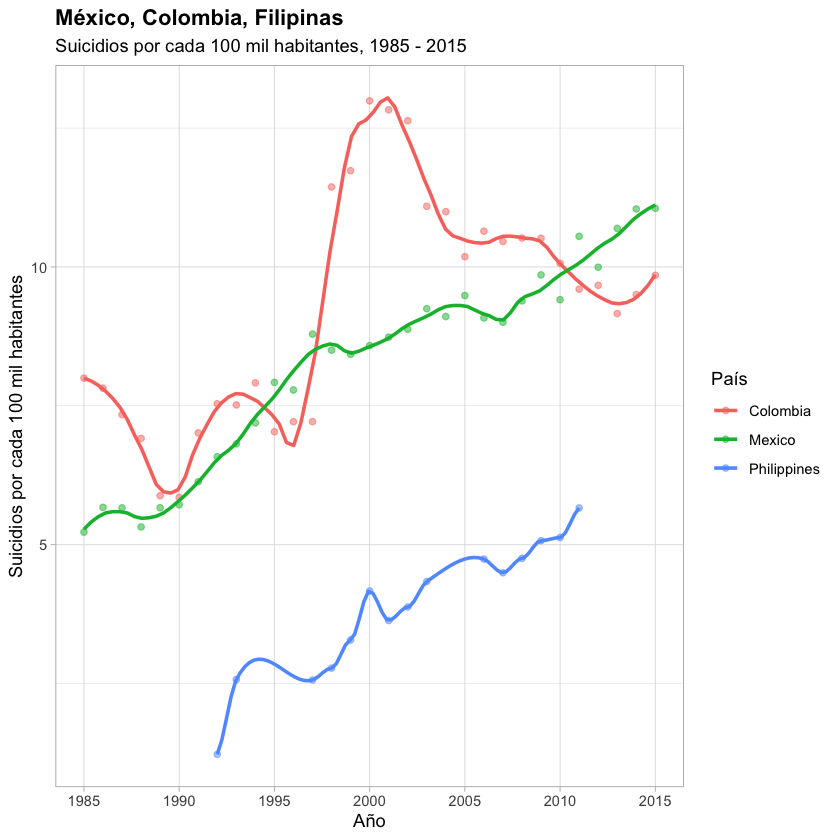

In [95]:
data_filtered %>%
  filter(age %in% c("15-24", "25-34", "35-54"), sex == "Male") %>%
  group_by(country, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(se = F, span = 0.2) + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F) + 
  labs(title = "México, Colombia, Filipinas", 
       subtitle = "Suicidios por cada 100 mil habitantes, 1985 - 2015", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "País") +
  theme(plot.title=element_text(face="bold")) 

In [96]:
# Hallazgos:

# La tendencia de Colombia a lo largo de la década de 1990 fue muy preocupante.
# Nuevamente, México muestra la tendencia actual más obvia y preocupante.
# La tendencia en Filipinas es la menos preocupante, aunque crea incertidumbre la falta de datos.

### Hombres - 15-24 años, 25-34 y 35-54

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1991.9”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5.095”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.389”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1991.9”Warning message i

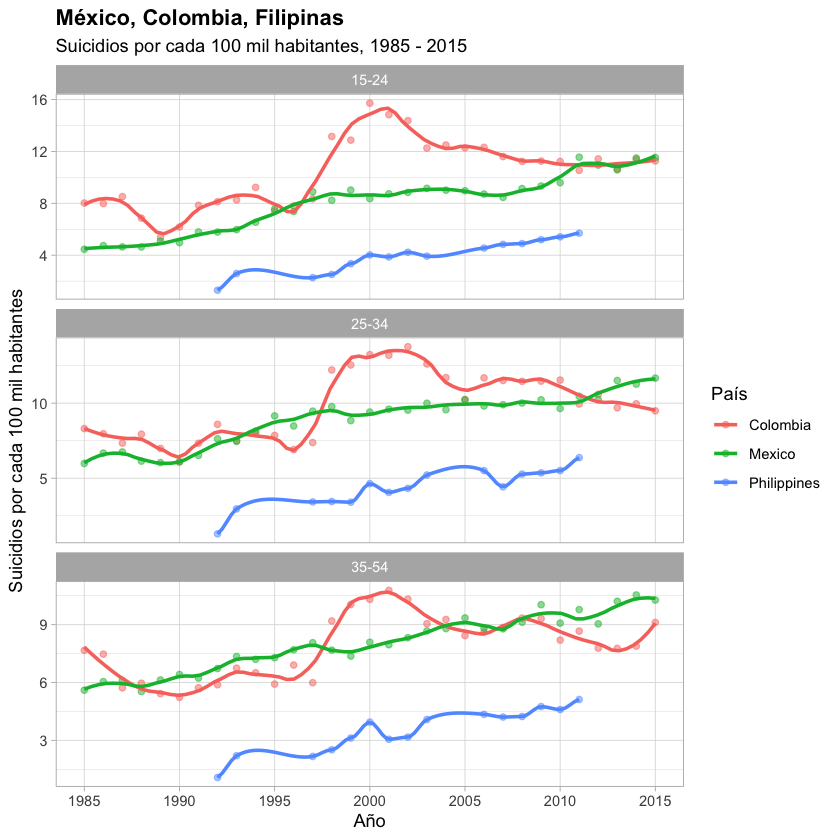

In [97]:
data_filtered %>%
  filter(age %in% c("15-24", "25-34", "35-54"), sex == "Male") %>%
  group_by(country, age, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(se = F, span = 0.2) + 
  facet_wrap(~ age, nrow = 3, scales = "free_y") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F) + 
  labs(title = "México, Colombia, Filipinas", 
       subtitle = "Suicidios por cada 100 mil habitantes, 1985 - 2015", 
       x = "Año", 
       y = "Suicidios por cada 100 mil habitantes", 
       col = "País") +
  theme(plot.title=element_text(face="bold")) 

In [ ]:
# Hallazgos:

# En la última decada, la tasa de suicidios en México y Colombia para jovenes de 15 - 24 años es practicamnte la misma
# Para los demás rangos de edad, México cuenta con los indices mas preocupantes.

# Es interesante analizar este tipo de datos con países que comparten características similares a México, con ello
# se puede observar que probablemente las causas de suicidio son las mismas.